In [1]:
from skimage import io
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
from skimage.color import (separate_stains, combine_stains,
                            hdx_from_rgb, rgb_from_hdx,rgb2hed, hed2rgb) 

from skimage import img_as_ubyte
from skimage.exposure import rescale_intensity
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import precision_score,recall_score,accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets

# Funciones

In [2]:
#Leer el conjunto de imagenes
def LeerImagenes(imagenes):
    imgs=[]
    for x in range(0,len(imagenes)):
        imgs.append(io.imread(imagenes[x]))
    MImagenes=np.array(imgs)
    
    return MImagenes

In [3]:
#Crea matriz con las etiquetas de las imagenes
def Etiquetas(imagenes):
    etiquetas=[]
    for x in range(0,len(imagenes)):
        Clasificacion =imagenes[x].split('-') 
        for i in range(0,len(Clasificacion)) :
            Valores=(Clasificacion[2])
            Numero=Valores.split('_')
        etiquetas.append(int(Numero[1]))
    return etiquetas

In [4]:
#Aplico filtro al conjunto de imagenes ingresados cono paramentro
def AplicarFiltro(MImagenes):
    imgs_con_filtro=[]
    for x in range(0,len(MImagenes)):
        ihc_hdx = rgb2hed(MImagenes[x])
        null = np.zeros_like(ihc_hdx[:, :, 0])
        ihc_h = hed2rgb(np.stack((ihc_hdx[:, :, 0], null, null), axis=-1))
        ihc_d = hed2rgb(np.stack((null, ihc_hdx[:, :, 1], null), axis=-1))
        ihc_x = hed2rgb(np.stack((null, null, ihc_hdx[:, :, 2]), axis=-1))

        h = rescale_intensity(ihc_hdx[:, :, 0], out_range=(0, 1),
                      in_range=(0, np.percentile(ihc_hdx[:, :, 0], 99)))
        d = rescale_intensity(ihc_hdx[:, :, 2], out_range=(0, 1),
                      in_range=(0, np.percentile(ihc_hdx[:, :, 2], 99)))
    
        zdh = np.dstack((null, d, h))
        imgs_con_filtro.append(zdh)
    Imagenes_con_fitro=np.array(imgs_con_filtro)
    return Imagenes_con_fitro

# PREPROCESAMIENTO

In [5]:
# Constantes
data_source = "../data/"
models_dir = '../saved_models/'
train_imgs = glob(f"{data_source}training/*.png")
test_imgs = glob(f"{data_source}test/*.png")

In [6]:
X_train=AplicarFiltro(LeerImagenes(train_imgs))
y_train=Etiquetas(train_imgs)
X_test=AplicarFiltro(LeerImagenes(test_imgs))
y_test=Etiquetas(test_imgs)

In [7]:
n_classes = 4
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print(Y_train[1])

[0. 0. 0. 1.]


In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [9]:
print(len(X_train))
print(len(X_test))

1600
320


# Creación de CNN

In [10]:
# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(300,300,3)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(100, activation='relu'))
# output layer
model.add(Dense(4, activation='softmax'))

In [11]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# training the model for 10 epochs
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10
13/13 [==============================] - 56s 4s/step - loss: 75.6337 - accuracy: 0.3500 - val_loss: 29.3667 - val_accuracy: 0.4781
Epoch 2/10
13/13 [==============================] - 47s 4s/step - loss: 17.0822 - accuracy: 0.5337 - val_loss: 11.7105 - val_accuracy: 0.5938
Epoch 3/10
13/13 [==============================] - 46s 4s/step - loss: 6.6009 - accuracy: 0.7100 - val_loss: 4.6672 - val_accuracy: 0.6750
Epoch 4/10
13/13 [==============================] - 45s 3s/step - loss: 3.6327 - accuracy: 0.8037 - val_loss: 1.3227 - val_accuracy: 0.7812
Epoch 5/10
13/13 [==============================] - 43s 3s/step - loss: 1.4984 - accuracy: 0.8825 - val_loss: 0.8840 - val_accuracy: 0.8344
Epoch 6/10
13/13 [==============================] - 42s 3s/step - loss: 0.5790 - accuracy: 0.9044 - val_loss: 1.6370 - val_accuracy: 0.6562
Epoch 7/10
13/13 [==============================] - 42s 3s/step - loss: 0.2689 - accuracy: 0.9488 - val_loss: 0.8926 - val_accuracy: 0.8531
Epoch 8/10
13/13

In [12]:
X_pred=model.predict(X_test)

In [13]:
print(X_pred)

[[1.0000000e+00 2.6106284e-15 0.0000000e+00 0.0000000e+00]
 [9.9999034e-01 9.6999820e-06 3.2615518e-30 1.4720967e-27]
 [1.0000000e+00 1.5283163e-17 0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 2.7504020e-22 9.3282445e-04 9.9906725e-01]
 [0.0000000e+00 2.5143390e-22 1.0192941e-05 9.9998975e-01]
 [0.0000000e+00 6.0995874e-23 2.2982588e-06 9.9999774e-01]]


# Evaluación 

In [14]:
Tabla=np.array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])
class_names=['0' '1' '2' '3']

In [15]:
classifier = svm.SVC(kernel='linear').fit(Tabla, Tabla.argmax(axis=1))
predicted_labels = classifier.predict(X_pred)

In [16]:
cnf_matrix = confusion_matrix(Y_test.argmax(axis=1), predicted_labels)
print(cnf_matrix)

[[77  3  0  0]
 [ 3 55 13  9]
 [ 0  3 48 29]
 [ 0  0  0 80]]


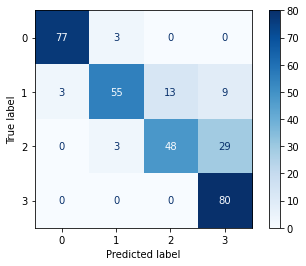

In [17]:
disp = plot_confusion_matrix(classifier, X_pred, Y_test.argmax(axis=1),
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues)
plt.show()

In [19]:
print(cnf_matrix.sum(axis=0))
print(np.diag(cnf_matrix) )
print(cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) )

[ 80  61  61 118]
[77 55 48 80]
[ 3  6 13 38]


In [22]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

In [23]:
FP

array([ 3.,  6., 13., 38.])

In [24]:
FN

array([ 3., 25., 32.,  0.])

In [25]:
TP

array([77., 55., 48., 80.])

In [26]:
TN

array([237., 234., 227., 202.])

In [27]:
TPR

array([0.9625, 0.6875, 0.6   , 1.    ])

In [28]:
PPV

array([0.9625    , 0.90163934, 0.78688525, 0.6779661 ])

In [29]:
print(classification_report(y_test, predicted_labels, digits=3))

              precision    recall  f1-score   support

           0      0.963     0.963     0.963        80
           1      0.902     0.688     0.780        80
           2      0.787     0.600     0.681        80
           3      0.678     1.000     0.808        80

    accuracy                          0.812       320
   macro avg      0.832     0.812     0.808       320
weighted avg      0.832     0.812     0.808       320

